## Import package
- StratifiedKFold for Cross Validation
- lightgbm/xgboost/catboost/ExtraTreesClassifier/RandomForestClassifier which is classifier for prediction
- StandardScaler which make sample features standard

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from math import sqrt
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import scipy.stats as stats
from scipy.stats import skew

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, auc, roc_curve, recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # show chinese
plt.rcParams['axes.unicode_minus']=False 

import itertools

import gc

### Helper Script
- Statistic features attribute distribution of each columns **resumetable()**
- Plot Confusion matrix **plot_confusion_matrix()**

In [2]:
def resumetable(df:pd.DataFrame)-> pd.DataFrame:
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [3]:
# plot confusion matrix
def plot_confusion_matrix(cm:np.array, classes:str, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
# plot roc
def plot_roc_curve(y_pred, y_pred_score):
    fpr, tpr, thresholds = roc_curve(y_pred, y_pred_score)
    roc_auc = auc(fpr, tpr)
    # Plot ROC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Data Pre-processing

In [5]:
train = pd.read_csv(r'../input/rs6-attrition-predict/train.csv')
test = pd.read_csv(r'../input/rs6-attrition-predict/test.csv')

In [6]:
resumetable(train)

Dataset Shape: (1176, 36)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,user_id,int64,0,1176,1374,1092,768,10.20
1,Age,int64,0,43,58,45,40,5.13
2,Attrition,object,0,2,No,No,No,0.63
3,BusinessTravel,object,0,3,Travel_Rarely,Travel_Rarely,Travel_Rarely,1.15
4,DailyRate,int64,0,783,605,950,300,9.46
5,Department,object,0,3,Sales,Research & Development,Sales,1.12
6,DistanceFromHome,int64,0,29,21,28,26,4.35
7,Education,int64,0,5,3,3,3,2.00
8,EducationField,object,0,6,Life Sciences,Technical Degree,Marketing,2.04
9,EmployeeCount,int64,0,1,1,1,1,0.00


In [7]:
resumetable(test)

Dataset Shape: (294, 35)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,user_id,int64,0,294,442,1091,981,8.20
1,Age,int64,0,43,36,33,35,5.10
2,BusinessTravel,object,0,3,Non-Travel,Travel_Rarely,Travel_Frequently,1.09
3,DailyRate,int64,0,267,635,575,662,8.01
4,Department,object,0,3,Sales,Research & Development,Sales,1.10
5,DistanceFromHome,int64,0,29,10,25,18,4.32
6,Education,int64,0,5,4,3,4,2.07
7,EducationField,object,0,6,Medical,Life Sciences,Marketing,2.09
8,EmployeeCount,int64,0,1,1,1,1,0.00
9,EmployeeNumber,int64,0,294,592,1545,1380,8.20


In [8]:
train.groupby('Attrition').count()['user_id']  # Uneven sample distribution

Attrition
No     988
Yes    188
Name: user_id, dtype: int64

In [9]:
object_features = [column for column in train if train[column].dtype == 'object']  # get the non-value features

In [10]:
object_features

['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

In [11]:
train[train['Over18'] == 'N']

,user_id,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


In [12]:
train.groupby(['Attrition'])['Over18'].count()

Attrition
No     988
Yes    188
Name: Over18, dtype: int64

### Visualization Features

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


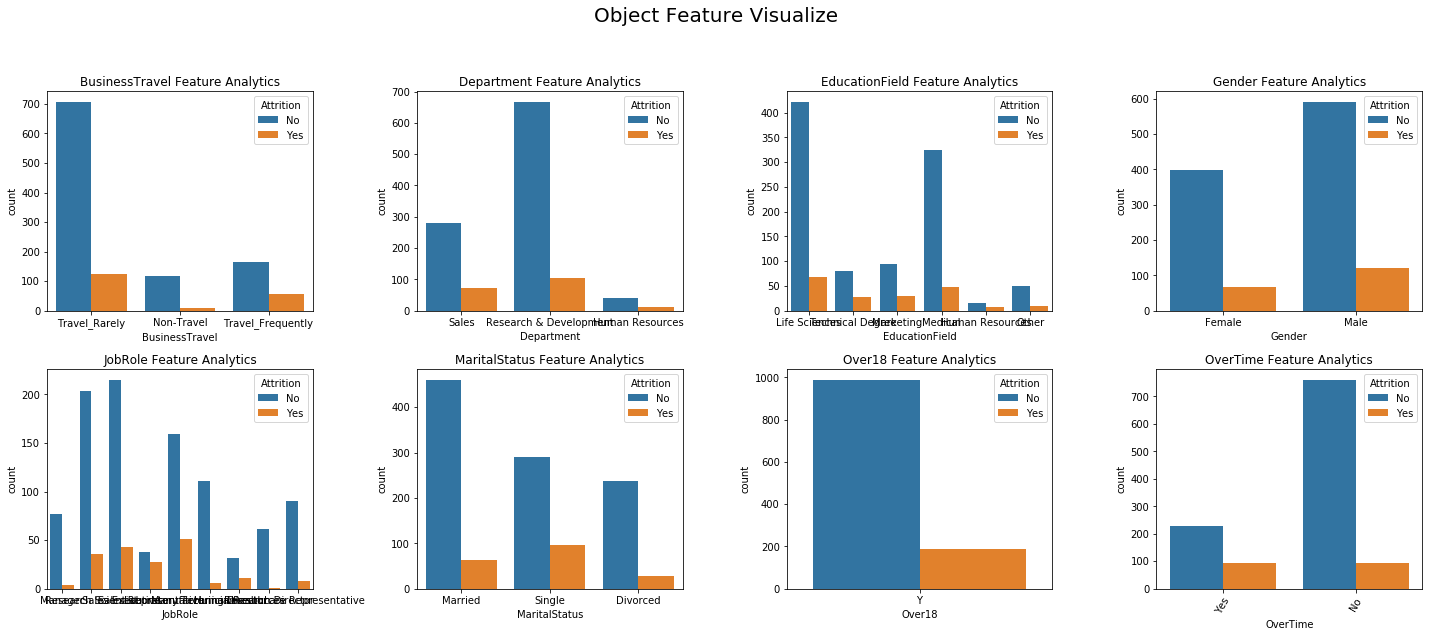

In [13]:
f, ax = plt.subplots(2, 4, figsize=(20, 8))
plt.xticks(rotation=60) 
tick_spacing = 3    # 设置密度，比如横坐标9个，设置这个为3,到时候横坐标上就显示 9/3=3个横坐标，
sns.countplot(x='BusinessTravel', hue='Attrition', data=train, ax=ax[0,0])
sns.countplot(x='Department', hue='Attrition', data=train, ax=ax[0,1])
sns.countplot(x='EducationField', hue='Attrition', data=train, ax=ax[0,2])
sns.countplot(x='Gender', hue='Attrition', data=train, ax=ax[0,3])
sns.countplot(x='JobRole', hue='Attrition', data=train, ax=ax[1,0])
sns.countplot(x='MaritalStatus', hue='Attrition', data=train, ax=ax[1,1])
sns.countplot(x='Over18', hue='Attrition', data=train, ax=ax[1,2])
sns.countplot(x='OverTime', hue='Attrition', data=train, ax=ax[1,3])

plt.subplots_adjust(wspace =0.2, hspace =0.5)#调整子图间距
ax[0,0].set_title('BusinessTravel Feature Analytics')
ax[0,1].set_title('Department Feature Analytics')
ax[0,2].set_title('EducationField Feature Analytics')
ax[0,3].set_title('Gender Feature Analytics')
ax[1,0].set_title('JobRole Feature Analytics')
ax[1,1].set_title('MaritalStatus Feature Analytics')
ax[1,2].set_title('Over18 Feature Analytics')
ax[1,3].set_title('OverTime Feature Analytics')
f.suptitle('Object Feature Visualize', size=20, y=1.1)
f.tight_layout()#调整整体空白
# todo 标签旋转

### Feature Dealing
- String label to Value label only

In [14]:
def extract_features(df, is_train=False):
    # target
    if is_train:
        attrition_dict = {'No':0,'Yes':1}
        df['Attrition'] = df['Attrition'].map(lambda x: attrition_dict[x])
    # BusinessTravel
    businesstravel_dict = {'Non-Travel':0, 'Travel_Rarely':1, 'Travel_Frequently':2}
    df['BusinessTravel'] = df['BusinessTravel'].map(lambda x: businesstravel_dict[x])
    # Department
    department_dict = {'Sales':0, 'Research & Development':1, 'Human Resources':2}
    df['Department'] = df['Department'].map(lambda x: department_dict[x])
    # EducationField
    educationfield_dict = {'Life Sciences':0, 'Medical':1, 'Marketing':2, 'Technical Degree':3, 'Human Resources':4, 'Other':5}
    df['EducationField'] = df['EducationField'].map(lambda x: educationfield_dict[x])
    # Gender
    gender_dict = {'Male':0, 'Female': 1}
    df['Gender'] = df['Gender'].map(lambda x: gender_dict[x])
    # JobRole
    jobrole_dict = {'Sales Executive':0, 
                    'Research Scientist':1, 
                    'Laboratory Technician':2, 
                    'Manufacturing Director':3, 
                    'Healthcare Representative':4,
                    'Manager':5, 
                    'Sales Representative':6,
                    'Research Director':7,
                    'Human Resources':8
                   }
    df['JobRole'] = df['JobRole'].map(lambda x: jobrole_dict[x])
    # MaritalStatus
    maritalstatus_dict = {'Single':0, 'Married':1, 'Divorced':2}
    df['MaritalStatus'] = df['MaritalStatus'].map(lambda x: maritalstatus_dict[x])
    # Over18
    df = df.drop(['Over18'], axis=1)
    # OverTime
    overtime_dict = {'Yes':0, 'No':1}
    df['OverTime'] = df['OverTime'].map(lambda x: overtime_dict[x])
    return df

In [15]:
train_ex = extract_features(train, True)
test_ex = extract_features(test, False)

## Single Model
- use the xgboost model as the baseline model
- try to use svm linear kernel

### xgboost

#### Define model input and target

In [16]:
target = 'Attrition'  # model target (y)
features = [x for x in train_ex.columns if x not in ['Attrition', 'uesr_id', 'user_id']]  # delete invaild features / model input

In [17]:
train_x = train_ex[features]
train_y = train_ex[target]

#### Split train and test set
- The ratio of train set to test set maybe change the final score

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.40, random_state=1729)  # split train and test

#### Importance Feature Selector
- Don't need to select some importance features from raw featrues, because before selecting the score is $0.85$, and after selecting the score is $0.77$.

In [19]:
# clf = ExtraTreesClassifier(random_state=2020)
# selector = clf.fit(X_train, y_train)

In [20]:
# fs = SelectFromModel(selector, prefit=True)  # select feature from model

# X_train = fs.transform(X_train)
# X_test = fs.transform(X_test)
# test = fs.transform(test_ex[features])

#### Standardization Data
- When using the Tree structrue to class the data, Standardization and Normalization operation is unnecessary. you can see https://zhuanlan.zhihu.com/p/64362722

In [21]:
# ## standard data
# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)
# test = StandardScaler().fit_transform(test)

#### Define and Train Model

In [22]:
m2_xgb = xgb.XGBClassifier(n_estimators=1200, max_depth=9, seed=2020)
m2_xgb.fit(X_train, y_train, eval_metric="auc", verbose=False, eval_set=[(X_test, y_test)])
#  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
y_pre = m2_xgb.predict(X_test)
# calculate the auc score
print("Roc AUC: ", roc_auc_score(y_test, m2_xgb.predict_proba(X_test)[:,1], average='macro'))
# Roc AUC:  0.7726366656599214 - test_size=0.40  not-select importance feature
# Roc AUC:  0.770009060706735  - test_size=0.40  select importance feature
# Roc AUC:  0.7684385382059802 - test_size=0.40 not-select importance feature but standard data, so not need standard

Roc AUC:  0.7876472364844458


#### Result Analysis

Confusion matrix, without normalization
[[374  11]
 [ 64  22]]


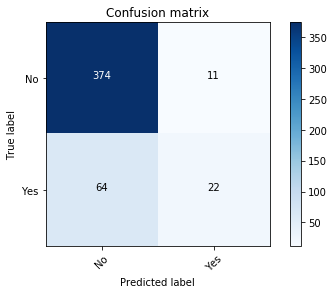

In [23]:
plot_confusion_matrix(confusion_matrix(y_test, y_pre), classes=['No', 'Yes'])

#### Some Conclusion
- The probability of predicting Yes to No is too high
- Further mining features - Feature engineering

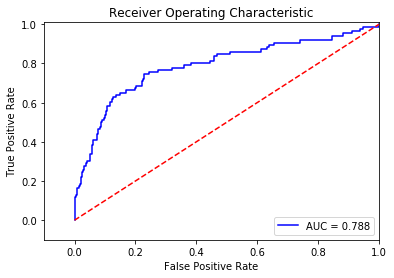

In [24]:
plot_roc_curve(y_test, m2_xgb.predict_proba(X_test)[:,1])

#### Predict the Testset

In [25]:
probs = m2_xgb.predict_proba(test_ex[features])   # feature don't need standard or normalization

In [26]:
test_id = test_ex.user_id

In [27]:
submission = pd.DataFrame({"user_id":test_id, "Attrition": probs[:,1]})

In [28]:
submission.head()

,user_id,Attrition
0,442,0.053475
1,1091,0.000256
2,981,0.004027
3,785,0.035001
4,1332,0.997389


#### Result save to file

In [29]:
submission.to_csv(f'result-{int(time.time())}.csv', index=False)

In [30]:
gc.enable()  # start gc

In [31]:
# # these code don't need run
# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.fit_transform(x_test)

### SVM

In [32]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

In [33]:
random_state = np.random.RandomState(2020)
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=random_state))

In [34]:
# X_train, X_test, y_train, y_test
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [35]:
plt_roc_curve(y_test, y_score)_roc_curve(y_test, y_score)

SyntaxError: invalid syntax (<ipython-input-35-59261485166e>, line 1)

## Multi-Model

In [36]:
NFOLDS = 5   # the variable for cross-validation folds
SEED = 2020

In [37]:
kf = KFold(n_splits =NFOLDS, shuffle=True, random_state=SEED)
kf = StratifiedKFold(n_splits=NFOLDS, random_state=SEED)
## the difference between *KFold* and *StratifiedKFold*, you can see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html 

In [38]:
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

class CatboostWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]
        
class LightGBMWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]


class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
#         print(x_train, y_train.value_counts())
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x)) # return proba https://stackoverflow.com/questions/58698313/reading-back-a-saved-lgbmclassifier-model

### Each Step of Cross Validation

In [39]:
def get_oof(clf, ntrain, ntest, x_train, y_train):  # out of fold, which means each step use the k-fold way to cross validate the dataset. 
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

#     for i, (train_index, test_index) in enumerate(kf.split(x_train)):
    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        if isinstance(x_train, np.ndarray):
            x_tr = x_train[train_index]
            y_tr = y_train[train_index]
            x_te = x_train[test_index]
        else:
            x_tr = x_train.iloc[train_index]
            y_tr = y_train.iloc[train_index]
            x_te = x_train.iloc[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### Algorithm Parameters

In [40]:
et_params = {
    'n_jobs': 16,
    'n_estimators': 600,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
#     'silent': 1,
}

rf_params = {
    'n_jobs': 16,
    'n_estimators': 600,
    'max_features': 0.2,
    'max_depth': 12,
    'min_samples_leaf': 2,
#     'silent': 1,
}

xgb_params = {
    'booster':'gbtree',
    'seed': 2020,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.75,
    'learning_rate': 0.075,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'nrounds': 200
}

catboost_params = {
    'iterations': 600,
    'learning_rate': 0.5,
    'depth': 10,
    'l2_leaf_reg': 40,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.7,
    'scale_pos_weight': 5,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'allow_writing_files': False,
    'silent': True,
}

lightgbm_params = {
    'n_estimators':600,
    'learning_rate':0.1,
    'num_leaves':123,
    'colsample_bytree':0.8,
    'subsample':0.9,
    'max_depth':15,
    'reg_alpha':0.2,
    'reg_lambda':0.4,
    'min_split_gain':0.01,
    'min_child_weight':2,
    'silent': 1,
}

### Define Multi-Model

In [41]:
xg = XgbWrapper(seed=SEED, params=xgb_params)
et = SklearnWrapper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
rf = SklearnWrapper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
cb = CatboostWrapper(clf=CatBoostClassifier, seed = SEED, params=catboost_params)
lg = LightGBMWrapper(clf=LGBMClassifier, seed = SEED, params = lightgbm_params)

### Result

In [42]:
x_train_multi = train_ex[features]
y_train_multi = train_ex[target]
x_test = test_ex[features]
ntrain_multi = x_train_multi.shape[0]
ntest = x_test.shape[0]

In [43]:
# clf, ntrain, ntest, x_train, y_train
xg_oof_train, xg_oof_test = get_oof(xg, ntrain_multi, ntest, x_train_multi, y_train_multi)
et_oof_train, et_oof_test = get_oof(et, ntrain_multi, ntest, x_train_multi, y_train_multi)
rf_oof_train, rf_oof_test = get_oof(rf, ntrain_multi, ntest, x_train_multi, y_train_multi)
cb_oof_train, cb_oof_test = get_oof(cb, ntrain_multi, ntest, x_train_multi, y_train_multi)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [44]:
print("XG-CV: {}".format(roc_auc_score(y_train_multi, xg_oof_train)))
print("ET-CV: {}".format(roc_auc_score(y_train_multi, et_oof_train)))
print("RF-CV: {}".format(roc_auc_score(y_train_multi, rf_oof_train)))
print("CB-CV: {}".format(roc_auc_score(y_train_multi, cb_oof_train)))
# Fisrt Time
# XG-CV: 0.8016840382461883
# ET-CV: 0.810093461969162
# RF-CV: 0.8077299939701955
# CB-CV: 0.7908357739684727

XG-CV: 0.8074984925488845
ET-CV: 0.803476828322853
RF-CV: 0.8011510466017745
CB-CV: 0.8032668619174778


### Cross Validation(CV) Conclusion
- Catboost algorithm is some week. so not emumate the model for predict

### Concat the result

In [45]:
x_train_fin = np.concatenate((xg_oof_train, et_oof_train, rf_oof_train), axis=1)
x_test_fin = np.concatenate((xg_oof_test, et_oof_test, rf_oof_test), axis=1)

print("{},{}".format(x_train_fin.shape, x_test_fin.shape))

(1176, 3),(294, 3)


### LogisticRegression Model predict the results

In [46]:
logistic_regression = LogisticRegression()
logistic_regression.fit(x_train_fin, y_train_multi)
result = pd.DataFrame()
result['user_id'] = test_ex['user_id']
result['Attrition'] = logistic_regression.predict_proba(x_test_fin)[:,1]

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [47]:
result[['user_id', 'Attrition']].to_csv(f'result-{int(time.time())}.csv', index=False, float_format='%.8f')

## Imbalance Data
- Resamping: Undersampling and Oversampling

In [48]:
count_class_0, count_class_1 = train_ex.Attrition.value_counts()
df_class_0, df_class_1 = train_ex[train_ex[target] == 0], train_ex[train_ex[target] == 1]

In [49]:
df_class_1.sample(5)

,user_id,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1033,286,44,1,2,920,1,24,3,0,1,...,4,80,1,19,0,1,1,0,0,0
684,415,34,1,2,296,0,6,2,2,1,...,4,80,1,3,3,2,2,2,1,0
100,689,20,1,1,129,1,4,3,3,1,...,2,80,0,1,2,3,1,0,0,0
397,762,26,1,2,342,1,2,3,0,1,...,2,80,1,6,2,3,3,2,1,2
1001,928,44,1,1,621,1,15,3,1,1,...,4,80,1,10,2,3,10,7,0,5


### Under-Sampling
- Random under-sampling

Random under-sampling:
1    188
0    188
Name: Attrition, dtype: int64


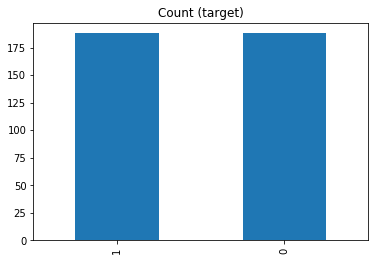

In [50]:
df_class_0_under = df_class_0.sample(count_class_1)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)
print('Random under-sampling:')
print(df_train_under.Attrition.value_counts())

df_train_under.Attrition.value_counts().plot(kind='bar', title='Count (target)');

In [51]:
x_train_under_sampling = df_train_under[features].copy()
y_train_under_sampling = df_train_under[target]
ntrain_under_sampling = y_train_under_sampling.shape[0]

#### Multi-Model

In [52]:
# clf, ntrain, ntest, x_train, y_train
xg_oof_train, xg_oof_test = get_oof(xg, ntrain_under_sampling, ntest, x_train_under_sampling, y_train_under_sampling)
et_oof_train, et_oof_test = get_oof(et, ntrain_under_sampling, ntest, x_train_under_sampling, y_train_under_sampling)
rf_oof_train, rf_oof_test = get_oof(rf, ntrain_under_sampling, ntest, x_train_under_sampling, y_train_under_sampling)
cb_oof_train, cb_oof_test = get_oof(cb, ntrain_under_sampling, ntest, x_train_under_sampling, y_train_under_sampling)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [53]:
print("XG-CV: {}".format(roc_auc_score(y_train_under_sampling, xg_oof_train)))
print("ET-CV: {}".format(roc_auc_score(y_train_under_sampling, et_oof_train)))
print("RF-CV: {}".format(roc_auc_score(y_train_under_sampling, rf_oof_train)))
print("CB-CV: {}".format(roc_auc_score(y_train_under_sampling, cb_oof_train)))
# XG-CV: 0.773228836577637
# ET-CV: 0.7693809416025351
# RF-CV: 0.7701731552738798
# CB-CV: 0.7287799909461297

XG-CV: 0.7513297872340425
ET-CV: 0.7715878225441377
RF-CV: 0.7705126754187415
CB-CV: 0.7337313263920325


#### Single-model

In [54]:
X_train, X_test, y_train, y_test = train_test_split(x_train_under_sampling, y_train_under_sampling, test_size=0.40, random_state=1729)  # split train and test

In [55]:
m2_xgb = xgb.XGBClassifier(n_estimators=1600, max_depth=8, seed=2020)
m2_xgb.fit(X_train, y_train, eval_metric="auc", verbose=False, eval_set=[(X_test, y_test)])
#  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
y_pre = m2_xgb.predict(X_test)
# calculate the auc score
print("Roc AUC: ", roc_auc_score(y_test, m2_xgb.predict_proba(X_test)[:,1], average='macro'))

Roc AUC:  0.7867957746478872


### Over-Sampling
- 0.79561

Random over-sampling:
1    988
0    988
Name: Attrition, dtype: int64


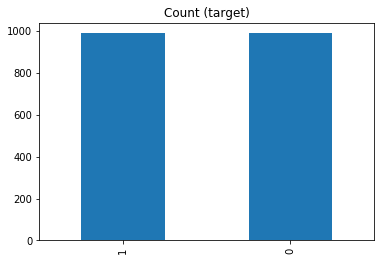

In [56]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_train_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_train_over.Attrition.value_counts())

df_train_over.Attrition.value_counts().plot(kind='bar', title='Count (target)');

In [57]:
x_train_over_samping = df_train_over[features]
y_train_over_samping = df_train_over[target]
ntrain_over_samping = y_train_over_samping.shape[0]

In [58]:
gc.enable()

In [59]:
# clf, ntrain, ntest, x_train, y_train
xg_oof_train, xg_oof_test = get_oof(xg, ntrain_over_samping, ntest, x_train_over_samping, y_train_over_samping)
et_oof_train, et_oof_test = get_oof(et, ntrain_over_samping, ntest, x_train_over_samping, y_train_over_samping)
rf_oof_train, rf_oof_test = get_oof(rf, ntrain_over_samping, ntest, x_train_over_samping, y_train_over_samping)
cb_oof_train, cb_oof_test = get_oof(cb, ntrain_over_samping, ntest, x_train_over_samping, y_train_over_samping)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [60]:
print("XG-CV: {}".format(roc_auc_score(y_train_over_samping, xg_oof_train)))
print("ET-CV: {}".format(roc_auc_score(y_train_over_samping, et_oof_train)))
print("RF-CV: {}".format(roc_auc_score(y_train_over_samping, rf_oof_train)))
print("CB-CV: {}".format(roc_auc_score(y_train_over_samping, cb_oof_train)))

XG-CV: 0.994181186382337
ET-CV: 0.9946247684767822
RF-CV: 0.9927490206362997
CB-CV: 0.9952609451064597


In [61]:
x_train_fin = np.concatenate((xg_oof_train, et_oof_train, rf_oof_train, cb_oof_train), axis=1)
x_test_fin = np.concatenate((xg_oof_test, et_oof_test, rf_oof_test, cb_oof_test), axis=1)

print("{},{}".format(x_train_fin.shape, x_test_fin.shape))

(1976, 4),(294, 4)


In [62]:
logistic_regression = LogisticRegression()
logistic_regression.fit(x_train_fin, y_train_over_samping)
result = pd.DataFrame()
result['user_id'] = test_ex['user_id']
result['Attrition'] = logistic_regression.predict_proba(x_test_fin)[:,1]

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [63]:
result[['user_id', 'Attrition']].to_csv(f'result-{int(time.time())}.csv', index=False, float_format='%.8f')

### SMOTE(Synthetic Minority Oversampling Technique)
- Leaderboard:0.82202**

In [64]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [65]:
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(train_ex[features], train_ex[target])

In [66]:
x_test = x_test.values

In [67]:
x_test.shape

(294, 33)

In [68]:
y_sm.shape

(1976,)

In [69]:
# clf, ntrain, ntest, x_train, y_train
xg_oof_train, xg_oof_test = get_oof(xg, X_sm.shape[0], ntest, X_sm, y_sm)
et_oof_train, et_oof_test = get_oof(et, X_sm.shape[0], ntest, X_sm, y_sm)
rf_oof_train, rf_oof_test = get_oof(rf, X_sm.shape[0], ntest, X_sm, y_sm)
cb_oof_train, cb_oof_test = get_oof(cb, X_sm.shape[0], ntest, X_sm, y_sm)

In [70]:
print("XG-CV: {}".format(roc_auc_score(y_sm, xg_oof_train)))
print("ET-CV: {}".format(roc_auc_score(y_sm, et_oof_train)))
print("RF-CV: {}".format(roc_auc_score(y_sm, rf_oof_train)))
print("CB-CV: {}".format(roc_auc_score(y_sm, cb_oof_train)))

XG-CV: 0.9690670638758215
ET-CV: 0.9641425855201692
RF-CV: 0.9706672376206789
CB-CV: 0.9729076857512826


In [71]:
x_train_fin = np.concatenate((xg_oof_train, et_oof_train, rf_oof_train, cb_oof_train), axis=1)
x_test_fin = np.concatenate((xg_oof_test, et_oof_test, rf_oof_test, cb_oof_test), axis=1)

print("{},{}".format(x_train_fin.shape, x_test_fin.shape))

(1976, 4),(294, 4)


In [72]:
logistic_regression = LogisticRegression()
logistic_regression.fit(x_train_fin, y_train_over_samping)
result = pd.DataFrame()
result['user_id'] = test_ex['user_id']
result['Attrition'] = logistic_regression.predict_proba(x_test_fin)[:,1]

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [73]:
result[['user_id', 'Attrition']].to_csv(f'result-{int(time.time())}.csv', index=False, float_format='%.8f')

### Over-sampling followed by under-sampling
- we will do a combination of over-sampling and under-sampling, using the **SMOTE** and **Tomek links** techniques:

In [74]:
from imblearn.combine import SMOTETomek

In [75]:
smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(train_ex[features], train_ex[target])

In [76]:
X_smt.shape

(1884, 33)

In [77]:
xg_oof_train, xg_oof_test = get_oof(xg, X_smt.shape[0], ntest, X_smt, y_smt)
et_oof_train, et_oof_test = get_oof(et, X_smt.shape[0], ntest, X_smt, y_smt)
rf_oof_train, rf_oof_test = get_oof(rf, X_smt.shape[0], ntest, X_smt, y_smt)
cb_oof_train, cb_oof_test = get_oof(cb, X_smt.shape[0], ntest, X_smt, y_smt)

In [78]:
print("XG-CV: {}".format(roc_auc_score(y_smt, xg_oof_train)))
print("ET-CV: {}".format(roc_auc_score(y_smt, et_oof_train)))
print("RF-CV: {}".format(roc_auc_score(y_smt, rf_oof_train)))
print("CB-CV: {}".format(roc_auc_score(y_smt, cb_oof_train)))

XG-CV: 0.9683523334279958
ET-CV: 0.9611264374033655
RF-CV: 0.9695615328095348
CB-CV: 0.9750756172213433


In [79]:
x_train_fin = np.concatenate((xg_oof_train, et_oof_train, rf_oof_train, cb_oof_train), axis=1)
x_test_fin = np.concatenate((xg_oof_test, et_oof_test, rf_oof_test, cb_oof_test), axis=1)

print("{},{}".format(x_train_fin.shape, x_test_fin.shape))

(1884, 4),(294, 4)


In [80]:
logistic_regression = LogisticRegression()
logistic_regression.fit(x_train_fin, y_smt)
result = pd.DataFrame()
result['user_id'] = test_ex['user_id']
result['Attrition'] = logistic_regression.predict_proba(x_test_fin)[:,1]

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [81]:
result[['user_id', 'Attrition']].to_csv(f'result-{int(time.time())}.csv', index=False, float_format='%.8f')

## Focal Loss
- [FL for lightgbm](https://github.com/jrzaurin/LightGBM-with-Focal-Loss)
- [FL for xgboost](https://github.com/jhwjhw0123/Imbalance-XGBoost)
- [Custom Loss Function for xgboost and lightgbm](https://www.zhangqibot.com/post/ml-custom-loss-lgbm-xgb/)
- [Custom Loss Function for catboost](https://cloud.tencent.com/developer/article/1513081)